In [13]:
import pandas as pd
import sqlite3
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pyproj
import plotly.express as px
%matplotlib inline
import plotly

In [2]:
conn = sqlite3.connect("result/nationbuilder.db")

In [3]:
df = pd.read_sql("select * from people", conn)

In [4]:
for col in df.columns:
    if (df[col].values == None).sum() >= 22900:
        df.drop(col, axis=1, inplace=True)

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df.drop('profile_image_url_ssl', axis=1, inplace=True)
df['addr_lat'] = pd.to_numeric(df['addr_lat'])
df['addr_lng'] = pd.to_numeric(df['addr_lng'])

In [6]:
df.columns

Index(['created_at', 'do_not_call', 'do_not_contact', 'email', 'email_opt_in',
       'employer', 'first_name', 'has_facebook', 'id', 'is_twitter_follower',
       'is_volunteer', 'last_name', 'mobile', 'mobile_opt_in', 'middle_name',
       'note', 'occupation', 'phone', 'precinct_id', 'recruiter_id', 'sex',
       'signup_type', 'support_level', 'tags', 'twitter_id', 'twitter_name',
       'updated_at', 'work_phone_number', 'volunteer', 'preferred_language',
       'newsletter_preferred_frequency', 'do_not_publish', 'why_atlas',
       'addr_address1', 'addr_address2', 'addr_address3', 'addr_city',
       'addr_county', 'addr_state', 'addr_country_code', 'addr_zip',
       'addr_lat', 'addr_lng', 'addr_street_number', 'addr_street_prefix',
       'addr_street_name', 'addr_street_type', 'addr_street_suffix',
       'addr_unit_number', 'addr_zip4', 'addr_zip5'],
      dtype='object')

In [7]:
df.loc[~df['addr_lat'].isna()][['first_name','last_name','addr_country_code', 'addr_lat', 'addr_lng']].groupby('addr_country_code')['first_name'].count().sort_values()

addr_country_code
PS       1
BZ       1
CF       1
CI       1
RE       1
      ... 
HK    1214
IT    1483
GB    1496
US    1903
EC    6055
Name: first_name, Length: 170, dtype: int64

In [14]:
df.loc[df['addr_country_code'] == 'HU'][['first_name','last_name','addr_country_code', 'addr_lat', 'addr_lng']]

first_name    last_name addr_country_code   addr_lat   addr_lng
2614       Mahdi       Jafari                HU  47.502393  19.086043
3275      Csenge       Urszán                HU  47.400565  18.839944
3337    Barnabás     Springer                HU  46.195537  18.269987
4359      Balázs                             HU  47.162494  19.503304
13394   Fruzsina         Papp                HU  47.497912  19.040235
14668     Monika     Andrasek                HU  47.391972  18.904544
15822      √Åkos  Albert-Nagy                HU  47.497912  19.040235
16165      Hanna   Rudersdorf                HU  46.253010  20.141425
20893     Zsuzsa      Csetvei                HU  47.497912  19.040235
20975    Katalin       Tarján                HU  47.497912  19.040235
22874     István      Hegedűs                HU  47.497912  19.040235

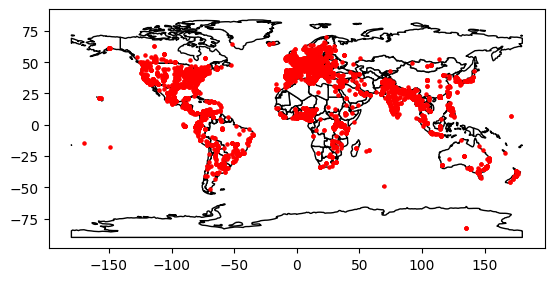

In [17]:
# Create a new GeoPandas dataframe from the Pandas dataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['addr_lng'], df['addr_lat']))

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map and the data
ax = world.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=5)

# Show the plot
plt.show()

In [23]:
map_df = gpd.read_file('source/world-administrative-boundaries/', encoding='utf-8')
map_df.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
members_per_country = df.groupby('addr_country_code')['created_at'].count().reset_index().rename(columns={'created_at': 'member'})
merged = pd.merge(map_df, members_per_country, left_on='iso_3166_1_', right_on='addr_country_code', how='left')
#map_df = map_df.dropna(subset='geometry')
merged = merged[['name', 'iso3', 'member', 'geometry']]
fig = px.choropleth(merged, geojson=merged['geometry'], locations=merged['name'], color="member")
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

name iso3  member  \
0            Ma'tan al-Sarra  NaN     NaN   
1                Switzerland  CHE   114.0   
2                     Jersey  NaN     NaN   
3                    Austria  AUT    85.0   
4                   Portugal  PRT   172.0   
5                 Luxembourg  LUX    27.0   
6                 Kazakhstan  KAZ     NaN   
7                      Aruba  ABW     1.0   
8                   Holy See  VAT     NaN   
9          Equatorial Guinea  GNQ     NaN   
10                   Jamaica  JAM     NaN   
11                   Estonia  EST     4.0   
12                     Niger  NER     NaN   
13                    Belize  BLZ     1.0   
14                   Morocco  MAR    53.0   
15  Northern Mariana Islands  MNP     NaN   
16             Kuril Islands  NaN     NaN   
17                    France  FRA   388.0   
18                    Serbia  SRB     8.0   
19                   Uruguay  URY    11.0   

                                             geometry  
0   POLYGON ((33.25104 21.99977, 34.15064 21.99603...  
1   POLYGON ((9.56672 47.54045, 9.55980 47.50209, ...  
2   POLYGON ((-2.01500 49.21417, -2.02111 49.17721...  
3   POLYGON ((16.94618 48.61907, 16.94333 48.57333...  
4   POLYGON ((-7.43185 37.25319, -7.41903 37.18055...  
5   POLYGON ((6.36217 49.45939, 6.32833 49.46916, ...  
6   POLYGON ((87.34820 49.09262, 87.31638 49.09777...  
7   POLYGON ((-69.87486 12.41528, -69.88224 12.411...  
8   POLYGON ((12.44799 41.90062, 12.44577 41.90192...  
9                                                None  
10  POLYGON ((-77.68861 18.48639, -77.64002 18.479...  
11                                               None  
12  POLYGON ((14.99789 23.00059, 15.00694 22.95944...  
13                                               None  
14  POLYGON ((-2.94694 35.32916, -2.96618 35.31663...  
15                                               None  
16                                               None  
17                                               None  
18  POLYGON ((20.26102 46.11485, 20.31403 46.06986...  
19  POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...

In [14]:
plotly.offline.plot(fig, filename='result/test.html')

'result/test.html'